# Setup

In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

# Import the MatLab prior work

from other_algs.teralasso import TeraLasso
from other_algs.EiGLasso import EiGLasso

# Standard imports

from new_validation import *
from generate_data import *
from regularizers import *

# Matplotlib
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--','-.',':'])
color_cycler = cycler('color',['k','r','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

# For determining connected components
import igraph as ig

# For timing
import timeit
from statistics import median

In [133]:
def GmGM_basic(dataset, structure, λ, reg: Regularizer = None):
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

def GmGM_covariance_thresholding(dataset, structure, λ, reg: Regularizer = None, batch_axes: set[Axis] = None, verbose=False):
    """
    Here we assume the input has a batch axis named ''
    """
    if batch_axes is None:
        batch_axes = {''}

    # Get gram matrices
    presences: dict[str, dict[str, Optional[int]]] = get_axis_presence(structure)
    gram_matrices: dict[Axis, np.ndarray] = get_gram_matrices(
        dataset,
        presences,
        structure,
        batch_axes=batch_axes,
    )
    gram_matrices = shrink_sparsities(gram_matrices, {axis: λ for axis in gram_matrices.keys()})
    all_axes: list[Axis] = list(gram_matrices.keys())

    # Do covariance partitioning
    components_map: dict[Axis, ig.VertexClustering] = {}
    to_skip: dict[Axis, set[int]] = {axis: set({}) for axis in all_axes}
    new_dataset: dict[Modality, np.ndarray] = dict({})
    new_structure: dict[Modality, tuple[Axis, ...]] = dict({})

    for axis in all_axes:
        if axis in batch_axes:
            continue
        for modality, data in dataset.items():
            dimension = presences[axis][modality]
            gram_matrix: np.ndarray = gram_matrices[axis]
            thresh: np.ndarray = (gram_matrix + gram_matrix.T) != 0
            graph: ig.Graph = ig.Graph.Adjacency(thresh).as_undirected()

            # Get connected components
            components = graph.components()
            components_map[axis] = components

            for idx, component in enumerate(components):
                if len(component) == 1:
                    to_skip[axis].add(idx)
                    continue
                new_dataset[f'{modality}||{idx}'] = data.take(component, axis=dimension)
                new_structure[f'{modality}||{idx}'] = list(structure[modality])
                new_structure[f'{modality}||{idx}'][dimension] = f'{axis}||{idx}'
                new_structure[f'{modality}||{idx}'] = tuple(new_structure[f'{modality}||{idx}'])
        dataset = new_dataset
        structure = new_structure
        presences = get_axis_presence(structure)
        new_dataset = dict({})
        new_structure = dict({})

    if verbose:
        print(max([len(comp) for comp in components_map["axis_0"]]))
        print(min([len(comp) for comp in components_map["axis_0"]]))
        print(structure)

    # Run algorithm
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5,
    )

    if verbose:
        print("Out")

    # Reconstruct output
    reconstructed_output: dict[Axis, np.ndarray] = {
        axis: np.zeros_like(gram_matrices[axis])
        for axis in all_axes
        if axis not in batch_axes
    }
    #for axis, Psi in reconstructed_output.items():
    #    np.fill_diagonal(Psi, 1)

    for axis, Psi in output.items():
        original_axis = axis.split('||')[0]
        group_id = int(axis.split('||')[1])

        if group_id in to_skip[original_axis]:
            continue

        original_locations = np.array(components_map[original_axis].membership) == group_id
        # This is only time I've ever had to use np.ix_ - otherwise really obscure but happens ;)
        reconstructed_output[original_axis][np.ix_(original_locations, original_locations)] = Psi

    output = shrink_sparsities(reconstructed_output, {axis: λ for axis in all_axes})
    return output

# Experiment 1: Covariance Thresholding Performance

In [134]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [135]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_basic,
        "GmGM CovThresh": GmGM_covariance_thresholding,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 20),
        "GmGM CovThresh": 10**np.linspace(-3, 0, 20),
    },
    20,
    1,
    verbose=1
)

Attempt 1/20
Attempt 2/20
Attempt 3/20
Attempt 4/20
Attempt 5/20
Attempt 6/20
Attempt 7/20
Attempt 8/20
Attempt 9/20
Attempt 10/20
Attempt 11/20
Attempt 12/20
Attempt 13/20
Attempt 14/20
Attempt 15/20
Attempt 16/20
Attempt 17/20
Attempt 18/20
Attempt 19/20
Attempt 20/20


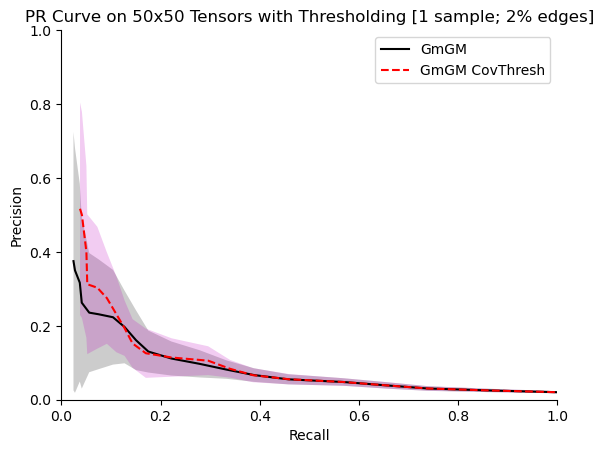

In [136]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors with Thresholding [1 sample; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [137]:
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2-cov-thresh.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2-cov-thresh.png", bbox_inches="tight")

# Experiment 2: Covariance Thresholding Runtime

In [153]:
def generate_timing_data_smart(
    algorithms: dict[str, callable],
    sizes: list[int],
    K: int,
    attempts: int, 
    num_samples: int,
    cutoff: int = 60,
    verbose: bool = False
):  
    includes: dict[str, bool] = {}
    times: dict[str, list[float]] = {}
    
    for algorithm in algorithms:
        includes[algorithm]: bool = True
        times[algorithm]: list[float] = []
    for d in sizes:
        if not any(includes.values()):
            if verbose:
                print("All algorithms timed out")
            break
        if verbose:
            print(f"Starting {(d,) * K}")

        # Generate Data
        structure = {
            "dataset_0": tuple(f"axis_{j}" for j in range(K))
        }
        num_groups = 2
        sub_generators = {
            f"axis_{i}": GroupedPrecMatGenerator([
                (PrecMatGenerator(
                    core_type="coreless",
                    mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
                ), d // num_groups)
                for _ in range(num_groups)
            ])
            for i in range(K)
        }
        generator = DatasetGenerator(
            structure=structure,
            generator=sub_generators,
            size={axis: d for axis in structure["dataset_0"]},
        )
        generator.reroll_Ψs()
        dataset = generator.generate({"dataset_0": num_samples})

        # Test algorithms
        for algorithm in algorithms.keys():
            if not includes[algorithm]:
                continue
            times[algorithm].append(0)
            durations = timeit.Timer(
                lambda: algorithms[algorithm](dataset, generator.structure)
            ).repeat(
                repeat=attempts,
                number=1
            )
            # Mean is better in this case because it only seems to help about 50% of the time,
            # so median flips between "helped" and "didn't help"!  Mean would show that, since
            # the speedup doesn't really hurt, on average it is good to use it.
            #times[algorithm][-1] = median(durations)
            times[algorithm][-1] = np.mean(durations)
            if times[algorithm][-1] >= cutoff:
                if verbose:
                    print(f"{algorithm} ran for longer than {cutoff} seconds")
                    print(f"{algorithm} is no longer being tracked")
                includes[algorithm] = False
            else:
                if verbose:
                    print(f"\t{algorithm}: {times[algorithm][-1]} Seconds")
                    print(f"\t\twith standard deviation {np.std(durations)}")
    print("Done")
    return times

In [154]:
algorithms = {
    "GmGM": lambda dataset, structure: GmGM_basic(dataset, structure, 0.01),
    "GmGM CovThresh": lambda dataset, structure: GmGM_covariance_thresholding(dataset, structure, 0.01, verbose=False),
}
size_data = [
    100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
    #1100, 1200, 1300, 1400, 1500, 1750, 2000, 2250, 2500,
    #3000, 3500, 4000,
]
timing_data = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data,
    K=2,
    attempts=50,
    num_samples=1,
    verbose=True
)

Starting (100, 100)
	GmGM: 0.014721217559999786 Seconds
		with standard deviation 0.0034690975531315397
	GmGM CovThresh: 0.017433886780636385 Seconds
		with standard deviation 0.001185476179966381
Starting (200, 200)
	GmGM: 0.039729593339725394 Seconds
		with standard deviation 0.008009483696332772
	GmGM CovThresh: 0.005482675819075666 Seconds
		with standard deviation 0.0004356606873704219
Starting (300, 300)
	GmGM: 0.1946844292181777 Seconds
		with standard deviation 0.004736906569585907
	GmGM CovThresh: 0.12398340501938947 Seconds
		with standard deviation 0.0015127768779005578
Starting (400, 400)
	GmGM: 0.36036475079949015 Seconds
		with standard deviation 0.003545918179948598
	GmGM CovThresh: 0.04009452662081458 Seconds
		with standard deviation 0.0008091049344659376
Starting (500, 500)
	GmGM: 0.5875354516383959 Seconds
		with standard deviation 0.008692935200202798
	GmGM CovThresh: 0.0403336549596861 Seconds
		with standard deviation 0.001211838397783637
Starting (600, 600)
	GmGM

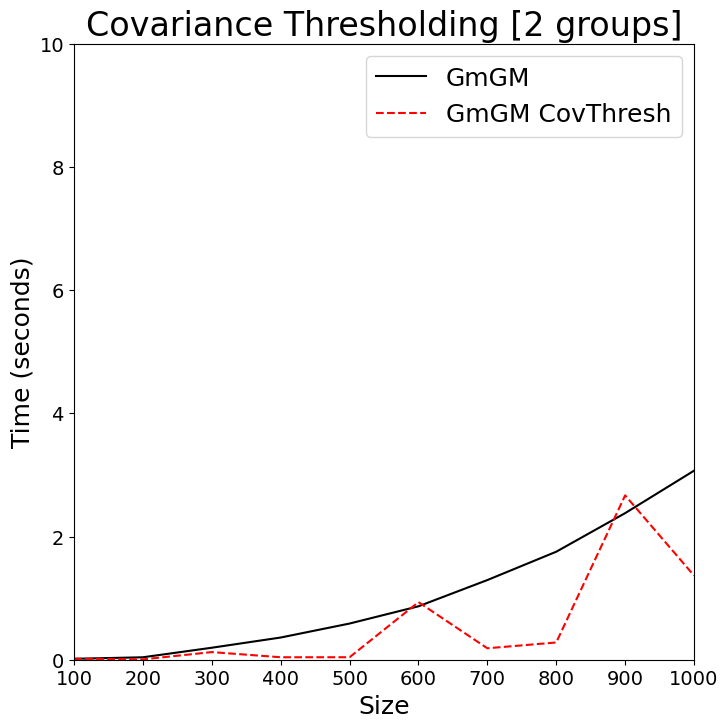

In [155]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data):
    ax.plot(
        size_data[:len(timing_data[algorithm])],
        timing_data[algorithm],
        label=algorithm,
        #linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Covariance Thresholding [2 groups]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 10])
ax.set_xlim([size_data[0], size_data[-1]])
ax.legend(fontsize=18)

In [156]:
fig.savefig("../out_figs/cov-thresh-runtime.png")
fig.savefig("../out_figs/cov-thresh-runtime.svg")

# Experiment 3: Priors

In [2]:
def GmGM_noprior(dataset, structure, λ, prior, reg: Regularizer = None):
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

def GmGM_prior(dataset, structure, λ, prior, reg: Regularizer = None):
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5,
        prior=prior,
        prior_type={axis: "wishart" for axis in structure["dataset_0"]}
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

In [3]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [10]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_noprior,
        "GmGM with Prior": GmGM_prior,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 20),
        "GmGM with Prior": 10**np.linspace(-3, 0, 20),
    },
    20,
    1,
    verbose=1,
    give_prior=True
)

Attempt 1/20
Attempt 2/20
Attempt 3/20
Attempt 4/20
Attempt 5/20
Attempt 6/20
Attempt 7/20
Attempt 8/20
Attempt 9/20
Attempt 10/20
Attempt 11/20
Attempt 12/20
Attempt 13/20
Attempt 14/20
Attempt 15/20
Attempt 16/20
Attempt 17/20
Attempt 18/20
Attempt 19/20
Attempt 20/20


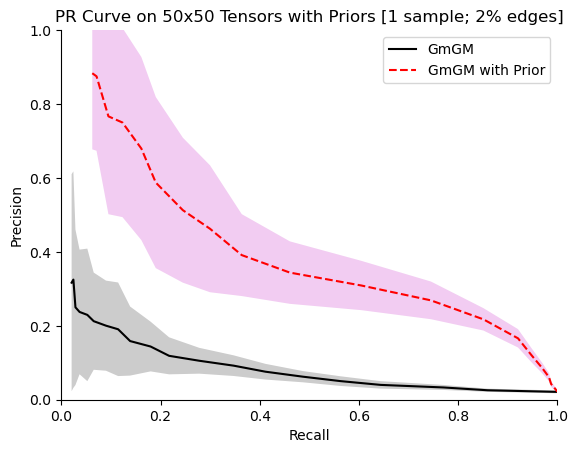

In [11]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors with Priors [1 sample; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [12]:
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2-cov-prior.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2-cov-prior.png", bbox_inches="tight")